### The following is from [HERE](https://geographicdata.science/book/notebooks/11_regression.html), then modified as the example is worked through

## Spatial Regression
Regression (and predicion more generally), provides us a perfect case to examine how spatial structure can help us inderstand and analyze our data. In this chaprer we discuss how spatial structure can be used to both validate and imprive predicion algorithms, ficusing on linear regression speciffically. 

### What is spatial regression and why should I care?

Usually, Spatial structure helps regression models in one of two ways, The first (and most clear) way space can have an impact on our data is when the process *generating* the data is itself inherently spatial. Here, thisk of somthing like the prices ofr a single family home. It;s often the case that individuals pay a premiium on their house price in order to live in a better school district for the same quality house. Alternativly, homes closer to noie or chemical polluters like waste watter tretment plants, recycling facilities, or wide highways, may actuallu be cheaper than we would otherwise anticipate. In cases like aethma incidence, the locations individuals tend to travel to throughout the day - such as their work of areas of recreation- mau have more of an impact on their health than their given residential address. In this case, it may be necessary to use the data *from other sites* to predict the asthema incidence at a given site. Regardless of the specific case at play here, *geography is a feature*: it directly helps us make predictions about outcomes *because the outcomes are obtained from a geographical process*

An alternative (and more skeptical understanding) reluctantly acknoledged geography's instrumental value. Often, in the analysis of predictive methods and classifiers, we are interested in analyzing what we get wrong. This in common in econometrics; an analyst may be concerned that the model *systematically* mis-predicts somme types of observations. If we know our model routinely performs poorly on a known set of observations or type fo input, we might make a better model if we can account for this. Among other kinds of error diagnostics, geography provides us with an explicitly useful embedding to assess structure in our errors. Mapping classification/prediction error can help us show whether or not there are *clusters of error* in our data. If we *know* that errors tend to be larger in some areas than other areas (or if error is "contigious" between observations), then we might be able to exploit this structure to bake better predictions. 

Spatial structure in our errors might arise from when geography *should be* an attribute somehow, but we are not sure exactally how to include it in our model. THey may also arise because there is some *other* feature whose omission causes the spatial patterns in the error we see. If this additional feature were included, the structure would disapper. Or, it might arise from the complex interactions and interdependencies between the features that we have chosen as predictors., resulting in an intrinsic structure in mis-prediction. Most of the predictors we use in models of social processes contain *embodied* spatial information: patterning ontrinsic to the feature that er get for free in the model. If we intend to or not, using a spatailly patterened predictor in a model can result in spatially patterned errorsl using more thatn one can amplify this effect. Thus, *regardless of whether or not the true preocess is explicitly geographic*, additional information about the spatial relationships between our observations or more information about nearby sites can make our predictions better. 

In this notebook, we build space into the traditional regression framework. We begin with a standard linear regression model, devoid of andy geographical reference. From there, we formalize space and spatial relationships in three main ways: 
* encoding it in exogenous variables
* through spatial heterogeneity, or as systematic variation of outcomes across space
* as dependence, or through the effect associated th the characteristics of spatial neighbors.
  
Throughout, we focus on the conceptual difffernces each approach entails rather than on the technical details. 

In [1]:
from pysal.lib import weights
from pysal.explore import esda
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Data: San Diego Airbnb

To learn a little about how regressoin works, we'll examine information about Airbnb properties in San Diego, CA. THis dataset contains house intrinsic charateristics, both continious (number of beds as in beds) and categorical (type of renting, of, in Airbnb jargon, property group as in the series of pg_X binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, d2balboa or neighborhood id, neighborhood_cleansed)

In [2]:
db = gpd.read_file("../data/air_bnb/regression_db.geojson")

These are the explanatory variables we will use throughout the notebook

In [3]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

### Non-Spatial Regression, A (Very) Quick Refresh

Before we discuss how to explicitly include space into the linear regression framework, lwt us show how basic regression can be carried out in Python, and how on can begin to interperate the results. By no means is this a formal and complete introduction to regtrsion, so if that is what you are looking for see [GH06](https://doi.org/10.1017/cbo9780511790942) (in particular chapters 3 and 4, which provide a fantastic, non-spatial introduction).

The core idea of linear regression is to explain the variation in a given (*dependent*) variable as a linear function fo a collection of other (*explanatory*) variables. For example, in our case, we may want to express the price of a house as a finction of the number of bedroome it has and whether it is a condominium or not. At the individual level, we express this as:

$P_i = \alpha + \sum\limits_{k}\bf{X}_{ik}\beta_k + \epsilon_{i}$

where $P_i$ in the Airbnb price of house $i$ and $\bf{X}$ is a set of covariates that we use to explain such price (e.g., No. of bedrooms and condominium binary variable). $\beta$ is a vector of parameters that give us information about in which way (e.g., increases price, decreases) and to what extent (e.g., var_a is responsible for 20% of price), $\alpha$ is a constant term that explains the average price of a house with all other variable set to zero. The term $\epsilon_{i}$ is an error term and captures elemente that influence the price of a house not included in $\bf{X}$, We can also express this relation in matrix form, excluding sub-indicies for $i$, which yields:

$P = \alpha + \bf{X}\beta + \epsilon$

A regression can be seen as a multivariate extention fo bivariate cerrelations. Indeed one way to interpreate the $\beta_{k}$ coefficents in the equation above is as the degree of correlation between the explanatory variable $k$ and the dependent variable, *keeping all the other explanatory variables constant*. Whrn one calculates bivatiate correlations, the coefficent of a variable is picling up the forrelation between the variables, but it is also subsuming into it the variation associates eith other correlated variables - also called confounding factors. Regression allows us to isolate the distinct effect that a single variable can have on the dependent one, once we *control* for those other variables. 

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g., statsmodels, scikit-learn, pysal). We will import the spreg module in Pysal:

In [4]:
from pysal.model import spreg

In the context of this notebook it makes sense to start with spreg, as that is the only library that will allow us to move into explicitly spatial econometric models. To fit the model specified in the equation above with $\bf{X}$ as the list defined, using ordinary least squares (OLS), we need only the following lien of code: 

In [5]:
# Fit the OLS model
m1 = spreg.OLS(
               db[["log_price"]].values,   # Dependent variable
               db[variable_names].values,  # Independent variables
               name_y="log_price",         # Dependent variable name
               name_x=variable_names,      # Independent variable names
              )

We use the command OLS, part of the spreg sub-package, and specify the dependent variable (the log of the price, so we can interpret results in terms of percentage change) and the explanatory iones. Note that both objects need to be arrays, we we extract them from the pandas dataframe object with .values.

In order to inspect the results of the model, we print the summary attribute:

In [6]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

A full detailed explanation of the output is beyond the scope of this notebook, so we ficus on the televant bits for our main purpose. The focus will be on the Coefficente section, which gives us the estimates for $\beta_{k}$ in our model. In other words, these numbners express the relationship between each explanatory variable and the dependent one, once the effict of confounding variables has been accounted for. Keep in mind that regression is no magic; we are only dicounting the effect of confounding factors that we include in the model, not of *all* potintially confounding factors.

Results are largely ase expected: houses tend to be significantaly more expensive if they accomodate morte people (variable accomodates), if they have more bathrooms and bedrooms, and if they are a condominium or part of the "other" category of house type. Conversly, given a number of rooms, houses with more beds (i.e., listings that are more "crowded") tend to go for cheaper, as it is the case for properties where one does not rent the entire house but only a room (variable rt_Private_room) or even shares it (variable rt_Shared_room). Of course, you might conceptually doubt the assumption that it is possible to *arbitrarily* change the number of beds within an Airbnb without eventually changing the number of people it accomodates, but methods to address these concerns using *interaction effects* won't be discussed here. 

### Hidden structures

In general, our modele peforms well, being able to predict slightly above two-thirds ($R^2 = 0.67$) of the variation in the mean nightly price using the covariates we've discussef above. But, our model might dispaly some clustering in the errors, which may be a problem as that violates the Independent and identically distributed (i.i.d) assumption that linear models ususally come built in with. To interrogate this, we can do a few things. One simple concept might be to look at the correlation between the error in predicting an Airbnb and  the error in predicting its nearest neighbor. To examine this, we might first want to want to split our data up by regions and see if we've got some spatial structure in our residuals. One reasonable theory might be that our model does not include any information about beaches, a critical aspect of why people live and vacation in San Diego. Therefore we might want to see whether of not our errors are higher or lower depending on whether a neighborhood is in a "beach" neighborhood - a neighborhood near the ocean. We use the code below to generate a visual representation of "beach" andd "no beach" neighborhoods.

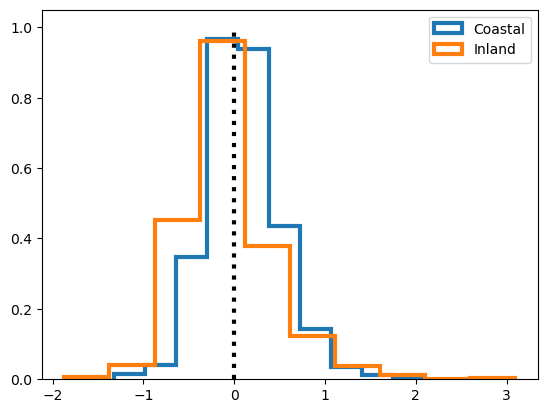

In [7]:
# Create a Boolean indicating if a property is coastal or not
is_coastal = db.coastal.astype(bool)

# Split our residuals (m1.u) between coastal and not
coastal_residuals = m1.u[is_coastal]
inland_residuals = m1.u[~is_coastal]

# Create a histogram of the distribution of coastal residuals
plt.hist(coastal_residuals, histtype="step", density=True, linewidth=3, label="Coastal")
# Creare a histogram of the distribution of inland residuals
plt.hist(inland_residuals, histtype="step", density=True, linewidth=3, label="Inland")

# Add a Line on x=0
plt.vlines(0,0,1,linestyle=":", color="k", linewidth=3)
# Add legend
plt.legend()
# Display
plt.show()

Whereas is appears that the neighborhoods on the coast have only slightly higher aveage errors (and have lower variance in their prediction errors), the two distributions are statistically significantly different from one another when compared with a classic $t$-test:

In [8]:
from scipy.stats import ttest_ind

ttest_ind(coastal_residuals, inland_residuals)

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

It is often better to use a straight-forward, data-driven testing and simulation methods rather than assuming the mathematical assumptions of the $t$-statistic are met. 

To do this, we can shuffle the assignments of coastal and inland to check whether or not there are differences in the distributions of the observed residual distibutions and random distributions. In this way, we shuffle the observations that are on the coast, and plot the resultind cumulative distributions. 

Below, we run 100 simulated re-assignments of districts to either "coast" or "inland", and compare the distributions of randomally assigned residuals to the observed distributions of residuals. Further, we do this plotting by the *emperical cumulative density function*, not the histogram directly. Thie is because the *emperical cumulative density function* is ususallly easier to examine visually, especially for subtle differences. 

The black lines represent our simulations, the colored patches below then represent the observes distribution of residuals (Figure 2). If the black lines tend to be on the left of the colored patch, then, the simulations (where prediction error is totally random with respect to our categories of "coastal" and "inland") tend to have more negative residuals than our actual model. If the black lines tend to be on the right, then they tend to have more positive residuals. As a refresher, positive residuals mean that our model is under-predicting, and negative residuals mean our model is over-predicting. Below, our eimulations provide direct evidence for the claim that our model may be systematically under-predicting coastal prices and over-predicting inland prices.

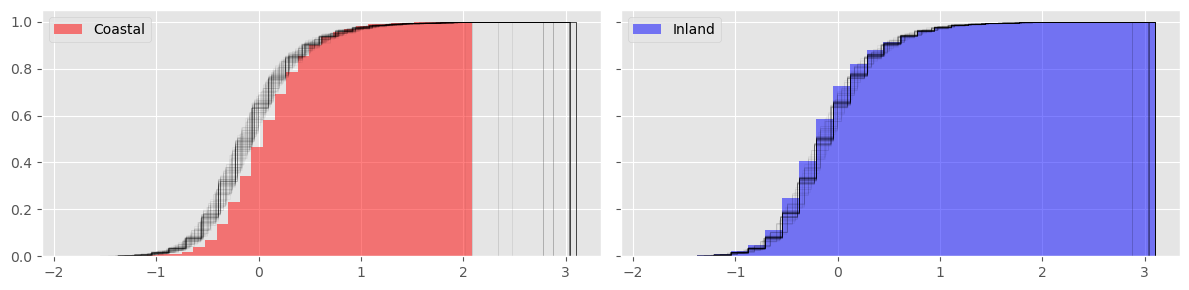

In [9]:
from matplotlib import style
plt.style.use('ggplot')

n_sim = 100      # Number of simulations to conduct

fig, axes = plt.subplots(1,2, figsize=(12,3), sharex=True, sharey=True)

axes[0].hist(
            coastal_residuals,
            color=["r"],
            alpha=0.5,
            density=True,
            bins=30,
            label="Coastal",
            cumulative=True,
          )

axes[1].hist(
            inland_residuals,
            color=["b"] ,
            alpha=0.5,
            density=True,
            bins=30,
            label="Inland",
            cumulative=True,
          )

for sim in range(n_sim):
    shuffled_residuals = m1.u[np.random.permutation(m1.n)]
    random_coastal = shuffled_residuals[is_coastal]
    random_inland = shuffled_residuals[~is_coastal]

    if sim == 0:
        label = "simulations"
    else:
        label=None
        axes[0].hist(
            random_coastal,
            color="k",
            alpha=0.05,
            density=True,
            histtype="step",
            bins=30,
            label=label,
            cumulative=True,
          )
        axes[1].hist(
            random_inland,
            color="k",
            alpha=0.05,
            density=True,
            histtype="step",
            bins=30,
            label=label,
            cumulative=True,
          )
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

Additionally, it may be the case that some neighborhoods are mre desireable thatn other neighborhoods due to unmodeled latent preferences or marketing. for instance, despite its procimity to the sea, living near camp Pendleton - A marine base in the northern part of the city - may incur fome significant penelties on area desirability due to noise and pollution. There are questions that domain knowledge privides and data analysis can help us answer. For us to determine whether or not this is the case, we may be interetef in the fill distribution fo model residuals within each neighborhood. 

To make this more clear, we'll first sort the neighborhoods by median residual in that neighborhood, and then make a boxplot (Figure 3), to examine the distribution of residuals in each neighborhood. 

/tmp/ipykernel_1040202/1427596682.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


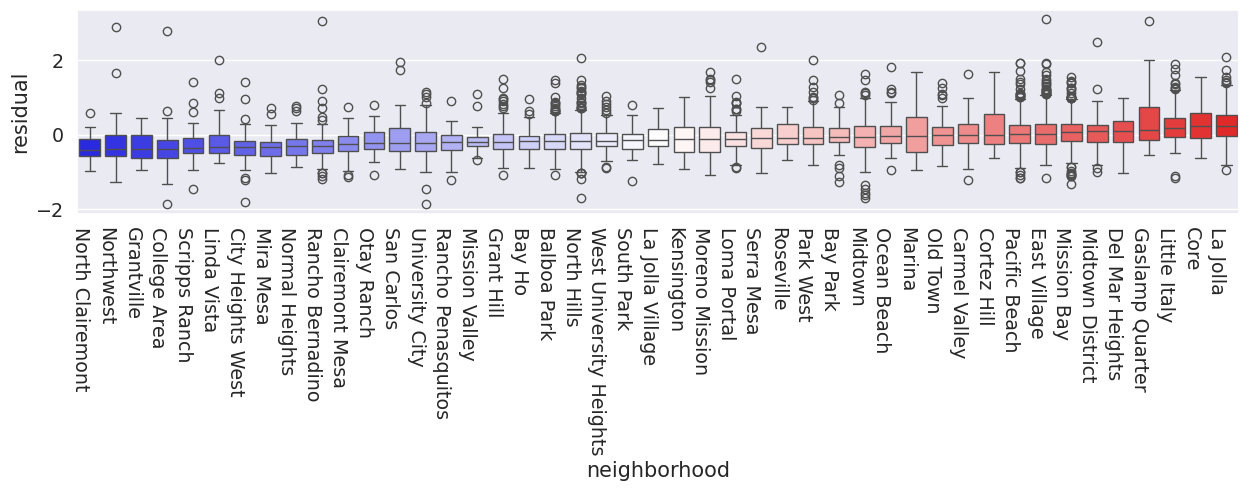

In [10]:
# Create column with resudual values from m1
db["residual"] = m1.u

# Obtain the median values of residuals for each neighborhood
medians = db.groupby("neighborhood").residual.median().to_frame("neighborhood_residual")

# Increase font size
sns.set(font_scale=1.25)

#set up fig
fig, ax = plt.subplots(1,1,figsize=(15,3))  # wo make subplots with one so we wn't need to call ax=plt.gca()

# Generate the boxplots from neighborhood distributions
sns.boxplot(
            x="neighborhood",
            y="residual",
            ax=ax,
            data = db.merge(
                            medians,
                            how="left",
                            left_on="neighborhood",
                            right_index=True)
                            .sort_values("neighborhood_residual"),
            palette="bwr",
           )
# Rotate the X labels for legibility
fig.autofmt_xdate(rotation=-90)
# Display
plt.show()


No neighborhood is disjoint from one another, but some do appear to be higher than others, such as the well-known downtown tourist neighborhood areas of the Gaslamp Quarter, Little Italy, or the Core. Thus, there may be a distinctive effect of intangible neighborhood fashionablness that matters in this model. 

Noting that many of the nost over - and under - predicted neighborhoods are near one another in the city. it may also be the case that there is some sort of *contagion* or spatial spillovers in the nightly rental price. This is often apperent when individuals seek to price their Airbnb listings to compete with other similar nearby listings. Since our model is not aware of this behavior, its errors tend to cluster. One exceponally simple way we can look into this structure is by examining the relationship betweeen an observeration;s residuals and its sorrounding residuals. 

To do this, we will use *spatial weights* rto represent the geographic relationship between observations. For this example, we'll start off with a $K N N$ matrix where $k = 1$, meaning we're focusing on the linkages of each Airbnb to their nearest other listing. 

In [11]:
knn = weights.KNN.from_dataframe(db, k=1)

/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


This means that, when we compute the *spatial lag* of that KNN weight and the rsidual, we get the residual of the Airbnb listing closest to eash observation. 

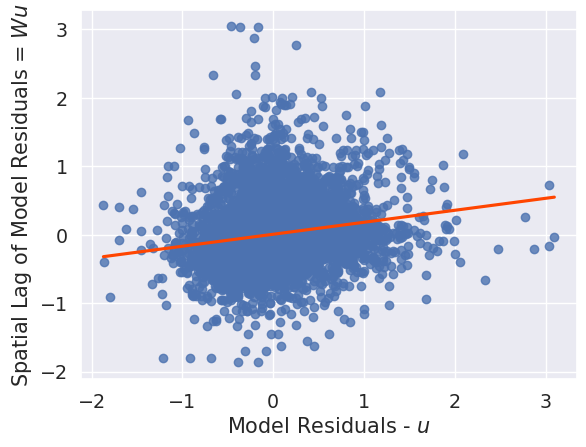

In [12]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)

ax = sns.regplot(
                 x=m1.u.flatten(),
                 y=lag_residual.flatten(),
                 line_kws={"color":"orangered"},
                 ci=None,
                );

ax.set_xlabel("Model Residuals - $u$");
ax.set_ylabel("Spatial Lag of Model Residuals = $W u$");

We see that our prediceion errors tend to cluster (Figure 4)! Above, we show the relationshi[ between our prediceion error at each site and the prediciton error at the site nearest to it. Here we are using the nearest site to stand in for the *sorroundings* of that Airbnb. This means that. when the model tends to over-predict a given Airbnb's noghtly log proce, sites around that Airbnb are more liekly to *also be over predicted* An interesting property of this relationship is that it eneds to stabalize as the number of nearest neighbors used to construct each Airbnb's sorroundings increases. 

#### The K-neighbor correlogram
It may be the case that spatial dependence in our mispredictions onlu matters for sites that are extremly close to one another, and it decays with quickly with distance. To investicater this we can examine correlation between each sit's residual and the *average* of the $k$-th nearest neighbors' residuals, increasing $k$ until the estimate stabalizes. The main idea is central to the geospatial concept, the *correlogram*, whhich goves the correlation between sites of an attribute being studied as distance increases. 

One quick way to check whether or not what we've seen is *unique* to *significant* is to compare it to what happens when we just assign neighbors randomly. If what we observe is substantially different from what emereges when neighbors are random, then the structure of the neighbors embeds a structure in the residuals. We won't spend too much on this theory specifically, but er can quickly and efficiently compute the correlation between our observed residuals and the spatial lag of an increasing k-nearest neighbor set:

In [13]:
correlations = []
nulls = []

for order in range(1,51, 5):
    knn.reweight(k=order, inplace=True) #inplace operation, to avoid copies
    knn.transform="r"    #row standardization
    lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
    random_residual = m1.u[np.random.permutation(len(m1.u))]
    random_lag_residual = weights.spatial_lag.lag_spatial(knn, random_residual) #identical to random neighbors in KNN
    correlations.append(np.corrcoef(m1.u.flatten(), lag_residual.flatten())[0,1]) # Pearson correlation coefficents
    nulls.append(np.corrcoef(m1.u.flatten(), random_lag_residual.flatten())[0,1]) # Pearson forrelation coefficents


/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids

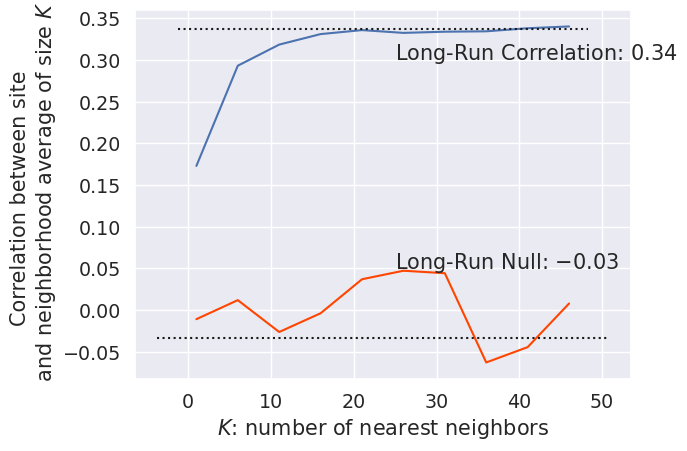

In [14]:
plt.plot(range(1,51,5), correlations)
plt.plot(range(1,51,5), nulls, color="orangered")
plt.hlines(np.mean(correlations[-3:]),
           *plt.xlim(),
           linestyle=":",
           color="k"
          )   #average of last three correlations we computed, where we expect it to stablaize
plt.hlines(np.mean(nulls[-3:]),
           *plt.xlim(),
           linestyle=":",
           color="k"
          )   #average of last three correlations we computed, where we expect it to stablaize
plt.text(
    s="Long-Run Correlation: ${:.2f}$".format(
        np.mean(correlations[-3:])
    ),
    x=25,
    y=0.3,
)
plt.text(
    s="Long-Run Null: ${:.2f}$".format(np.mean(nulls[-3:])),
    x=25,
    y=0.05,
)
plt.xlabel("$K$: number of nearest neighbors")
plt.ylabel(
    "Correlation between site \n and neighborhood average of size $K$"
)
plt.show()



Clearly these two curves are different. The observed correlation reaches a peak around $r = .34$ when around 20 nearest listings are used. Thie means that assing more than about 20 nearest neighbors does not significantally change the correlation in the residuals. Further, the lowest correlations is for the sinfle neares neighbor, and the correlation rapidly increases asmore neighbors are added close to the listing. This this means that there does appear to be an unmeasured spatial structure in the residuals, since they as more simmilar to one another when they are far near ve. far apart. Further, whereas it's not shown here (since computationally it becomes intracable), as the number of nearest nreighbors gets very large (approacjhing the number of observations in the dataset), the average of the $k$-th nearest neighbor's residuals goes to zero - which is the global average of the residuals. In other words, the correlation of the residuals and a vector that is nearly constant begins to approach zero, we have stablaized. 

The null correlations, however, use random chosen neighbors (without reassignment), This, since sampling is guarenteed to be random in this case, each average of $k$ randomly chosen neighbors is usually zero (or at least has a global mean of zero over a suitable number of itereations). So the correlation between the observed residual and the average of the $k$ randomly chosen residuals is also usually zero, This, increasing the number of randomly chosen neighbors does not significantly adjust the long-run average of zero. Taken together we can conclude that there is distinct postitive spatial dependence in the error, This means that our over- and under-predictions are likely to cluster.

Given the behavior we see in above (Figure 4), let's look at the stable $k = 20$ number of nearest neighbors (Figure 5). examining the relationship between this stable *sorrounding* average for the fical Airbnb, we can even find clusters in our own model error. Recalling *Local Moran* statistics, we can identify out predictions of the nightly (log) Airbnb prices tend to be significantly off:

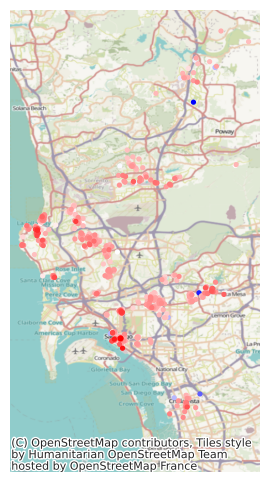

In [15]:
# Create a new set of weights, but use the nearest 20 neighbors
knn.reweight(k=20, inplace=True)

# Row standardize the weights
knn.transform = "R"

# Run LISAs on the residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)

#select only the LISA cluster cores
error_clusters = outliers.q %2 == 1

# Filter out clusters that fail to reach a significanc threshold
error_clusters = outliers.p_sim <= 0.001

# Add 'error_clusters' and 'local_I' columns and plot
ax = (
      db.assign(error_clusters = error_clusters, local_I = outliers.Is)
     .query( "error_clusters") # Retain ONLY the error clusters
     .sort_values("local_I")    # Sort by I valis so the largest is on top when we plot (for the visuals)
     .plot("local_I", cmap="bwr", marker=".", markersize=30, figsize=(4,6))
     )

# Add a basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes we do not need
ax.set_axis_off();


Thus, these areas tend to be locations where our model significantly under-predicts the nightly Airbnb price both for that specific observations and the observations in its immediate sorroundings. This is critical since, if we can identify how there areas are structured - if they have a *consistent geography* that we can model - then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting proces in other areas. Since significant under- and over-predictions do appear to cluster in a highly structured way, we might use a better model to fix the geography of our model errors. 

### Bringing Space Into the Regression Framework

There are many different ways that spatial structure shows up in our models, predictions, and our data, even if we do not explicitly intend to study it. Fortunately, there are nearly as many techniques, called *spatial regression* methods, that are designed to handle these sorts of structures. Spatial regression is about *explicitly* introducing space or geographical context into the statistical framework of a regression. 

Conceptually, we want to introduce space into our model whenever we think it plays an important role in the processess we are interested in, or when space is a reasonable proxy for other factors that we cannot but should include in our model. As an example of the former, er can imagine how houses at the seafront are probally more expensive than those in the second row, given the better views. To illistrate the latter, we can think of how the character of a neighborhood is important in determining the price of a house; however, it is very hard to identify and quantify "character" per se, althoughit may be easier to get at its spatial variation, hence a case of space as a proxy. 

Spatial regression is a large field of development in the econometrics and statistics literatures. In this brief introduction, we will consider two related but very different processes that give rise to spatial effects: spatial heterogeneity and spatial dependence. Before diving into them, we begin with another approach that introduces space in a regression model without modifying the model itself, but rather creates spatially explicit independent variables. For more rigirous treatments of the topics introduced here, we refer you to [[Ans03](https://doi.org/10.1177/0160017602250972), [AR14](https://geographicdata.science/book/notebooks/references.html#id11), [GH06](https://doi.org/10.1017/cbo9780511790942)]

### Spatial feature engineering: proximity variables
Using geographic information to "construct" new data is a common approach to bring in spatial information into the data analysis. Often this reflects the fact that processes are not the same everywhere in the map of analysis, or that geographical information may be useful to predict our outcome of interest. In this section we briefly present how to insert *spatial features*, or $X$ variables that are constructed from geographical relationships, in a standard linear model. We discuss spatial feature engineering explicitly in other notebooks, though, and the depth and extnet of spatial fewature engineering is difficult to over-state. Rather than detail, this section will show spatially explicit variables you engineer can be "plugged" into a model to improve its performance or to help you explain the underlying process of interest with more accuracy. One relevant proximity-driven variable that could influence our San Diego model in based on the listing's proximity to Balboa Park. A common tourist destination, Balboa Park is a centeral recreation hub for the city of San Diego, containing many museums and the San Diego Zoo. This it could be the case that people searching for Airbnbs in San Diego are willing to pay a premium to live closer to the park. If this were true *and* we omitted this from our model, we may indeed see a spatial pattern caused by this distance decay effect. 

Theerefore, this is sometimes called *spatially patterened covariate*: geographica information our model needs to make good predictions which we have left out of our model. THerefore, let's build a new model containing the distance to Balboa Park covariate. First, though, it helps to visulize (Figure 6) the stricture of the distance covariate itself. 

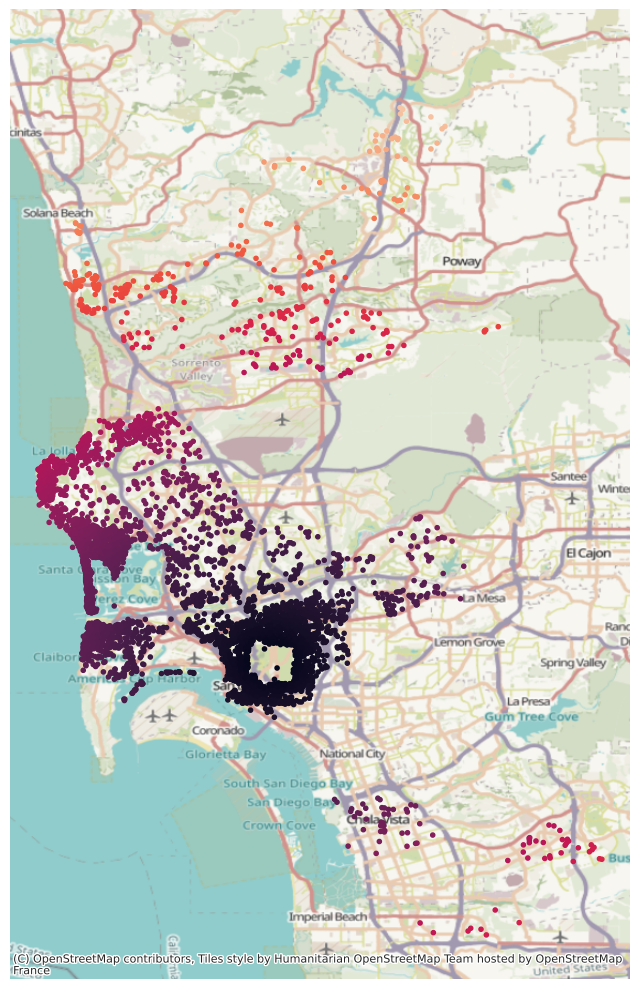

In [16]:
ax = db.plot("d2balboa",
             marker = ".",
             #markersize=20,
             figsize=(8,16),
            )
contextily.add_basemap(ax, crs=db.crs)
ax.set_axis_off()

To run a linear model that includes the additional variable of distance to the park, we add the name to the list of variables we include originally:

In [17]:
balboa_names = variable_names + ["d2balboa"]

And then fit the mofel using OLS class in Pysal's spreg:

In [18]:
m2 = spreg.OLS(
                db[["log_price"]].values,
                db[balboa_names].values,
                name_y="log_price",
                name_x=balboa_names,
)

When we inspect the regression diagnostics and output, we see that this covariate is not quite as helpful as we might anticipate:

In [19]:
pd.DataFrame(
    [[m1.r2, m1.ar2],[m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"]
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


In [20]:
# Set if table of regression coefficente

pd.DataFrame(
    {
        # Pull out regression coefficents and flatten as they are returned as N by 1 array
        "Coeff.":m2.betas.flatten(),
        # Pull out and flatten standard errrors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values ftom t-stat object
        "P-Value": [i[1] for i in m2.t_stat]
    },
    index=m2.name_x,
    )

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


And, there still apeears to be spatial structure in our model;s errors, as we can see (Figure 7)

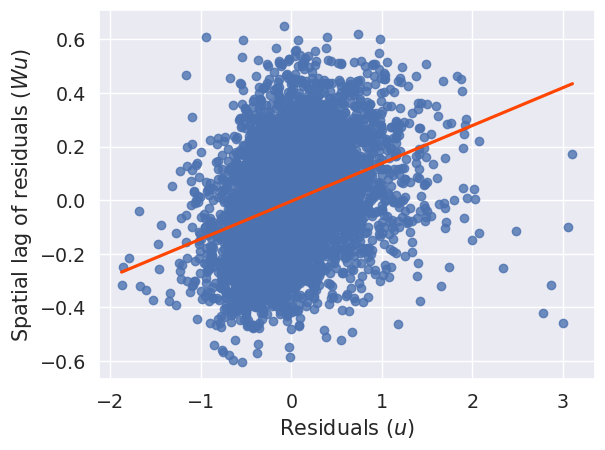

In [21]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = sns.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

Finally, the distance to Balboa Park variable does not fit our theory about how distance to amenitu should afffect the price of ann Airbnb; the foefficent estimate is *positive* (increasing with distance), meaning that people are paying a premium to be *further away* from Balboa Park. We eill revisit this result later on, when where consider spatial herterpgenity and will be able to shed some light on this. Furthermore, the noext notebook (spatial feature engineering) is an extensive treatment of spatial fixed effects, presentinf many more spatial feature engineering methods. Here, we only showed how to include these engineered features in the linear modeling framework. 

### Spatial Heterogeneity

So far we have assumed that our proximity variable might stand in foe a difficult-to-measure (latent) premium indiviuals pay when they're close to a recreational zone (in this case a park). Our approach in that case was to incorporate space through a vary specific channel, that is the distance to an amentiy we thought may be substantially influencing the final price. However, not all neighborhoods have the same housing prices; some neighborhoods may be systematically more expensive than others, regardless of their proximity to Balboa Park. If this is our case, we need a way to account for the fact that each neighborhood may experience these kinds of *gestalt*, unique effects that cannot be expressed as the sum of its parts. One way to do this is by capturing *spatial heterogeneity* (SH). At its most basic *spatial heterogeneity* means that parts of the model may vary systematically with geography, change in different places. For example, changes to the intercept $\alpha$, may reflect the fact that different areas have different baseline exposures to a given process. Changes to the slope terms, $\beta$, may indicate come kind of geographical mediating factor that mekse the relationship between the independent and dependent variables vary across space, such as when a governmental policy is not consistently applied across jurisdictions. Finally, changes to the variance of the residuals, commonly denoted as $\sigma^2$, can introduce spatial heteroskedasticity. We deal with the first two in this section. 

#### Spatial Fixed Effects

The literature commonly reffers to geographic variations of $\alpha$ as "spatial fixed effects (FE)". To illustrate them, let's consider the house price example from the previous secion. Simetimes, spatial fixed effects are said to capture "space as a proxy", in that we know the outcome varies over space, we (hope to) knpw the pattern it follows (in our case, by neighborhood) andd we can this incorporate that knowledge into the model by letting $\alpha$ vary accordingly. The rationale goes as follows: 
* Given we are only including a feew explanatory variables in the modelm it is likely we are missing some important factors that play a role at determining the price at which a house is sold. Some of these factors, however, are likely to vary systematically over space (e.g., differnt neighborhood charateristics).
* If this is the case, we can control for those unobserved factors by using traditional binary variables but basing their creation on a spatial rule. For example, let's include a binary variable for every neighborhood, indicating whether a given house (property) is located within that neighborhood (is_neighborhood_0 = False, is_neighborhood_1 = True, is_neighborhood_2= False, ..., is_neighborhood_n = False). Mathamatically we are fitting the following equation:

$\log P_i = \alpha_r + \sum\limits_kX_{ik}\beta_k + \epsilon_i$

where the main difference is that we are now allowing the constant term, $\alpha$, to vary by neighborhood $r$, $\alpha_r$.

Programmatally, we will show two different ways we can estimate this: 1)using statsmodels, and 2) spreg. forst we will use statsmodels, the econometricuan's toolbox in Python.   

In [22]:
import statsmodels.formula.api as sm

This package provides an formula-like API, which allows us to express the *equation* we wish to estimate directly, in the form of a string:

In [23]:
f = (
    "log_price ~" 
    + "+".join(variable_names) # The explanatory variable names, defined at the start of the notebook
    + "+ neighborhood - 1"    # adjust for 0 based indexing and 1 indexed neighborhoods
    )
print(f)

log_price ~accommodates+bathrooms+bedrooms+beds+rt_Private_room+rt_Shared_room+pg_Condominium+pg_House+pg_Other+pg_Townhouse+ neighborhood - 1


The *tilde* operator in this statement is usually read as "log_price is a function of ...", to account for the fact that many different model specifications can be fit accordingly to that functional relationship between log_price and our covariate list. Critically, note that the trailing "-1" term means that we are fitting this model without an intercept term. This is necessary, since including an intercept term alongside including unique means for every neighborhood would make the underlying systern of equations underspecified.

Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in statsmodels (note how the specification of the model, formulation and data are seperated from the fitting step):

In [24]:
m3 = sm.ols(f, data=db).fit()

We could rely on the summary2() method to print a similar summary report from the regression but given it is a lengthy one in this case, we will illistrate how you can extract the spatial fixed effects into a table for display. 

In [25]:
# Store variable names for all the spatial fixed effects

sfe_names = [i for i in m3.params.index if "neighborhood[" in i]  # "neighborhood[" with bracket, as neighborhoods are in this format: neighborhood[Balboa Park] 

# Create table
pd.DataFrame(
        {
            "Coef.": m3.params[sfe_names],
            "Std. Error": m3.bse[sfe_names],
            "P-value": m3.pvalues[sfe_names]
        }
    )

,Coef.,Std. Error,P-value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


The approach above shows how spatial fixed effects (FE) are a particular case of a linear regression with a categorical variable. Neighborhood membership is modeled using binary dummy variables. Thanks to the formula grammer used in statsmodels, we can express the model abstractly, and Python parses it, appropriatally creating the binary variables Pro Re Nata (as necessary).

The second approach leverages spreg Regimes functionality, We will see regimes below, but for now, think of them as a generalization of spatial fixed effects where not only $\alpha$ can vary. This framework allows the user to specify which variables are to be estimated separately for each group. In this case, instead of describing the model in a formula, we need to pass each element of the model as seperate elements - which by comparison is a bit more tedious. 

In [26]:
# spreg spatial fixed effect implementation

m4 = spreg.OLS_Regimes(
            y=db[["log_price"]].values,   # Dependent variable
            x=db[variable_names].values,  # Independent variables
            regimes=db["neighborhood"].tolist(), # Variable denoting neighborhood membership
            constant_regi="many",         # Allow the cosntant term to vary by group/regime
            cols2regi=[False] * len(variable_names),  # Variables to be allowed to vary (True) or kept constant (False) - here we set all as false
            regime_err_sep=False,         # Allow seperate sigma coefficents to be estimated by regime (false, so a single sigma)
            name_y="log_price",           # Dependent variable name for output
            name_x=variable_names,        # Independent variable names for output
          )
           

Similarly as above, we could rely on the summary attribute to print a report with all the results computes, For simplicity here, we sill only conform that, to the 12th decimal, the parameters estimated ate indeed the same we get from statsmodels:

In [27]:
import numpy as np

np.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([ 1.e-12, -3.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00,
       -0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00])

Economically speaking, what the neighborhood FEs we have introduced implay that, instead of implying that all house proces across San Diego as equal, we only derive variation from within each neighborhood, Remember that the inteception of $\beta_k$ is the effect of variable $k$ *given all other explanatory variables included remain constant*. By including a single variable for each ara, we are effectivly forcing the model to ocompare as equal only house proces that share the same value for each variable; or in other words, only houses located within the same area. Introducing FE affords a higher degree of isolation effects of the variables we introduce in the model because we can control for unobserved effects that align spatially with the distribution of the FE introduced (by neighborhood in this case). To make a map of neighborhood fixed effects, we need to process the results from our model slightly. 

First, we extract only the effects pertaining to the neighborhoods: 


In [28]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

Then we just ned to extract the neighborhood names from the series (remove "neighborhood[" and the trailing "]")

In [29]:
# Remove the characters we don't need
stripped = neighborhood_effects.index.str.strip("neighborhood[").str.strip("]")

# Reindex with our stripped neighborhood names
neighborhood_effects.index = stripped

# Convert this whole series to a dataframe
neighborhood_effects = neighborhood_effects.to_frame("fixed_effects")

# Print
neighborhood_effects.head()

,fixed_effects
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


Great, now we are back to our raw neighborhood names. Thes allow us to join to an auxilary file with the neighborhood boundries that is indexed using the dame names. 

In [30]:
# I can't find this file, so we can't map this out

sd_path = "../data/airbnb/neighborhoods.geojson"
#neighborhoods = gpd.read_file(sd_path)

In [ ]:
# # Plot base layer with all neighborhoods in grey
# ax = neighborhoods.plot(
#     color="k", linewidth=0, alpha=0.5, figsize=(12, 6)
# )
# # Merge SFE estimates (note not every polygon
# # receives an estimate since not every polygon
# # contains Airbnb properties)
# neighborhoods.merge(
#     neighborhood_effects,
#     how="left",
#     left_on="neighbourhood",
#     right_index=True
#     # Drop polygons without a SFE estimate
# ).dropna(
#     subset=["fixed_effect"]
#     # Plot quantile choropleth
# ).plot(
#     "fixed_effect",  # Variable to display
#     scheme="quantiles",  # Choropleth scheme
#     k=7,  # No. of classes in the choropleth
#     linewidth=0.1,  # Polygon border width
#     cmap="viridis",  # Color scheme
#     ax=ax,  # Axis to draw on
# )
# # Add basemap
# contextily.add_basemap(
#     ax,
#     crs=neighborhoods.crs,
#     source=contextily.providers.CartoDB.PositronNoLabels,
# )
# # Remove axis
# ax.set_axis_off()
# # Display
# plt.show()

#### Spatial Regimes

At the core of estimatins spatial FEs in the idea that. instad of assiming the sependent varoable behaves uniformaly over space, thee ate systematic effects following a geographical pattern that affects it's behavior. In other words, spatial FEs introduce econometrically the notion of spatial heterogeneity. They do this in the simplist foem possible: by allosieng the constant tem to vary geographically, the other elements of the regression are left untouched, thus apply uniformally across space. The idea of spatial regimes (SRs) ti the generlize the spatial FE apprech to allow only the fonstant term to vary but also andy other explanatory variables. This implies ther the equation we will be estimating is: 

$\log P_i = \alpha_r + \sum\limits_kX_{ki}\beta_{k-r} + \epsilon_i$

where we are not only allowinf the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).

To illistrate this approach, we will use the "spatial differentiator" of wheter a house in a coastal neighborhood or not (coastal_neig) to define regimes. The rationale behind this choice is that renting a house close to the ocean ight be a strong enough pull that people might be willing to pay at different *rates* for each of the hous's charateristics. 

To implment this in Python, we use the OLS_Regimes, class in spreg, which does most of the heavy lifting for us: 

In [31]:
# Pysal spatial regimes implementation for coastal or not (bool in db)

m5 = spreg.OLS_Regimes(
            y=db[["log_price"]].values,   # Dependent variable
            x=db[variable_names].values,  # Independent variables
            regimes=db["coastal"].tolist(), # Variable denoting coastal membership
            constant_regi="many",         # Allow the cosntant term to vary by group/regime
            #cols2regi=[True] * len(variable_names),  # Variables to be allowed to vary (True) or kept constant (False) - default "all" which allows all independent variables to vary
            regime_err_sep=False,         # Allow seperate sigma coefficents to be estimated by regime (false, so a single sigma)
            name_y="log_price",           # Dependent variable name for output
            name_x=variable_names,        # Independent variable names for output
          )

 

The result can be esxplored and interperated similarly to the previous ones. If tou inspect the summary attribute of the model, you will find the parameters for each variable mostly confome to theat you w would expect across both regimes. To compare them, we can plot them side-by-side on a bespoke table. 

In [32]:
# Results table
res = pd.DataFrame({"Coeff.": m5.betas.flatten(),  # Pull out regression coeffs and flatten to a nx1 array
                    "Std. Error": m5.std_err.flatten(),  # Same for standard error
                    "P-Value": [i[1] for i in m5.t_stat] # Same for pvalues from tstat object, iterate through and grab the p_val (idx=1) from the pstat object
                    
                   }, index = m5.name_x,
                  )

# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pd.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pd.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pd.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

An intereresting question arises around the reelevance of the regimes, *Are estimates of each variabl eacross regimes statistically different?* For this the model object also calculates for us what is called a CHow test. Thies is a statistic that tests the null hypothises that estimates from different regions are undistinguisable. If we reject the null, we have eveidence suggesting the regiomes actually make a difference. 

Results from the Chow test are avaliable in the summary attribute, or we can extract then directly from the model object, which we will do here. There are two types of Chow test. First is a global one that jointly tests for differences between two regimes: 

In [33]:
m5.chow.joint

(328.86902143026936, 7.11354876740665e-64)

The first variable represents the statistic, whereas the second one captures the p-values. In this case the two regimes are statistically different from one another. The next step then is to check whether each of the coefficents in our moedle differre across regimes. FOr this we can pull them into a table. 


In [34]:
pd.DataFrame(
            m5.chow.regi,            # Chow results by variable (stat and p_val)
            index = m5.name_x_r,     # Names of the variables
            columns=["Statistic", "P-value"]  #column names for the regi
            )

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


As we can see in theis table the results do seem to indeed differe across regimes, statistically speaking. This points to systamatic differences in the data generationg processes across spatial regions (different rates at whice variables are important as we vary spatial regimes)

### Spatial Dependence
As we have just discussed, SH is about the effects of a phenomena that atre *explicitly linked* to a geography and ther hence cause spatial variation and clustering. This encompasses many kinds of spatial efffects er may be interested in when we fit out linear regressions. However, in other cases, our focus in on the effect of the *spatial configuration* of the observations, and the extnet to ehich that has an effect on the outcome we are considering. For example, we might think that the proce of a house not only depends on shether it is a townhouse of apartment, but also on whether it is sorrounded by many more townhouses thatn skyscrapers with more apartments. This, we could hypothesize, might be related to the different "look and feel" a neighborhood with low-height, historic buildings has compared to one with modern high-rises. To the extent these two different spatial configurations enter differently the house proce determination process, we sill be interested in capturingnot onlythe charateristics of a house, but also of its sorrounding ones. This kind of spatial effectis fundamentially different than SH in that it is not related to inherent charateristics of the geography but relates to the charateristics of the observations in our dataset and, especially, to their spatial arrangment. We call this phenomenon by which the values of observations are related to eachother through distance *spatial dependence* [Ans88](https://doi.org/10.1007/978-94-015-7799-1).

Theere are several ways to introduce spatial dependence into an econometric framework, with varing degrees of economometric sophistication (see [Ans02](https://doi.org/10.1111/j.1574-0862.2002.tb00120.x) for a good overview). Common to all of them however is the way space is formally encapsulated: through *spatial weights matricies (**W**)*, which we discussed in prior notebooks. In this section, we consider three ways in which spatial dependence - through spatial weights matricies - can be incorporated into a regression framework. We bigin with the "least invasive" one, wehere we only modify the set of independent variables, and the move into more substantial modifications of the baseline linear model. 

#### Exogenous Effects: The SLX Model

Let us come back to the house price example we have been working with. So far, we have hypothesized that the price of a house rented in San Diego through Airbnb can be explained using information about its own charateristics as well as some relating to it's location - such as the neighborhood or distance to the main park in the city. However, it is also reasonable to think that prospective renters care about the set of neighbors a house has - not just the house itself - and would be willing to pay more for a house that was sorrounded by certian types of houses, and less if it was in the middle of other types. How can we test this idea?

When it comes to regression, the most straightforward way to introduce spatial dependence between the observations in the data is by considering not only a given explanatory variable, but also its spatial lag. Conceptually, this approach falls more within the area of spatial feature engineering, which embeds space in a model through the explanatory variables, rather than the functional form of the model, (we dive more into spatial feature engineering in other notebooks). But we think it is interesting to discuss it in this context fo two reasons: 
* First, it provides an "intellectual scaffold" to learn the intuition of building spatial dependence into regression.
* Second, because it illistrates how many if the techniques in spatial feature engineering can be embedded into a regression model (and, by extension, other predictive approaches).

In our example case, in addition to includinga dummy for ethe type of house (pg_XXX), we can also include the spatial lag of each type of house. This addition implies we are also including as explanatory factor the price of a given house the proportion of neighboring houses of each type. Mathamatically, this implies estimating the following model:

$log(P_i) = \alpha + \sum\limits_{k=1}^pX_{ij}\beta_j+\sum\limits_{k=1}^p\left(\sum\limits_{j=1}^N\omega_{ij}\chi_{jk}\right)\gamma_k+\epsilon_i$ 

where $\sum_{j=1}^N\omega_{ij}\chi_{jk}$ represents the spatial lag of the $k$th explanatory variable. This can be stated in *matrix* form using the spatial weights matrix, **W**, as:

$log(P_i) = \alpha + X\beta + WX\gamma + \epsilon$

Thie splits the model to focus on two main effectsL $\beta$ and $\gamma$. the $\beta$ effect describes the change in $y_i$ when $X_{ik}$ changes by one. <sup>[1]</sup> The subscript for site $i$ is important here: sincer we're dealing with **W** matrix, it's useful to be clear about where the chang occurs.

Indeed, this matters for the $\gamma$ effect, which represents the *inderect* association of a change in $X_i$ with the house price. This can be conceptualized in two ways. First, one could think of $\gamma$ as simply *the association between the price in a given house and a unit change in its average sorroundings*. This is useful and simple. But this interpretation bluse *where* this change might occur. In truth, a change in a variable as site $i$ will result in *spillover* to its sorroundings: wen $x_i$ changes, so too does the *spatial lag* of any sit near $i$. The precise size of the change in the spaial lag will depend on the structure of **W**, and it can be idfferent for every site it is connecte with. For example, think of a very highly connected "focal" site in a row standardized weight matrix. This focal site will not be strongly affected if a neighbor changes a single unit, since each site only contributes a small amount to the lag at the focal site. Alternativly, consider a site with only one neighbor: its lag will change by *exactaly* the amount its sole neighbor changes. This, to discover the exact inditect effect of a change $y$ caused by the change at a specific site $x_i$ you would need to compute the *change in the spatial lag*, and then use that as your *change* in $X$. We will discuss this in the following section. 

[1] Since we use the log price as the dependent variable, our $\beta$ coefficents can be interprated as the percentage change in the price associated with a unit change in the explanatory variable

In Python, we can calculate the spatial lag of each variable whose name starts with "pg_" by first creating a list of all those names, and then applying pysal's lag_spatial to each of them: 

In [35]:
# Select only columns in "db" containing the keyword 'pg_'

wx = ( db.filter( like="pg_")
       .apply(lambda y: weights.spatial_lag.lag_spatial(knn,y)) # Compute the spatial lag of each of those variables
       .rename(columns=lambda c: "w_" + c) # Rename the spatial lag, adding w_ to the original names
       .drop("w_pg_Apartment", axis=1) # Remove the lag of the binary variable for apartments
     )

Once computed, we can run the model using OLS estimation because - in this context - the spatial lags included do not violate and of the assumptions OLS relies on (they are essensially additional exogenous variables):

In [38]:
# Merge original vairables with the spatial lags in 'wx'
slx_exog = db[variable_names].join(wx)

# Fit linear model with 'spreg'
m6 = spreg.OLS(
            y=db[["log_price"]].values,   # Dependent variable
            x=slx_exog.values,            # Independent variables
            name_y="log_price",           # Dependent variable name for output
            name_x=slx_exog.columns.tolist(),        # Independent variable names for output
          )

 

As in the previous cases, printing the summary attribute of the model would show a fill report table. The variables we included in the original regression display similar behavior, wlbeit with small changes in size, and can nbe interprated also in a similar way. To focus on the aspects that differ from the previous models here, we will only pull out results for the variables for which we also included in their spatial lags:

In [41]:
# Collect names of variables of interest
vars_of_interest = db[variable_names].filter(like="pg_").join(wx).columns

# Build fill table of regression coefficents
pd.DataFrame({"Coeff.": m6.betas.flatten(),  # Pull out regression coeffs and flatten to a nx1 array
              "Std. Error": m6.std_err.flatten(),  # Same for standard error
              "P-Value": [i[1] for i in m6.t_stat] # Same for pvalues from tstat object, iterate through and grab the p_val (idx=1) from the pstat object
            
             }, index = m6.name_x,
            ).reindex(vars_of_interest).round(4)  # subset to vars_of_interest and round to 4 decimal places

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.5928,0.0690,0.0000
w_pg_House,-0.0774,0.0319,0.0152
w_pg_Other,0.4851,0.0551,0.0000
w_pg_Townhouse,-0.2724,0.1223,0.0260


The spatial lag of each type of property (w_pg_XXX) is the new addition. We observe that, except for the case of townhouses (same as with the binary variable, pg_Townhouse), they are all significant, suggesting our initial hypothesis on the role of the surrounding houses might indeed be at work here.

As an illistration, let's look at some of the direct.indirect effects. The direct effect of the pg_Condominium variable means that condominiums are typically ~11% more expensive ($\beta_{w_pg\_Condominium} = 0.1063$) thatn the benchmark property type, apartments. More relevant to this section, any given house sorrounded by condominiums *also* recieves a price premium. But, since $pg_{Condominium}$ is a dummy variable, the spatial laag at site $i$ represents the *parcentage* of properties near $i$ that are condominiums, which is between 0 and 1.<sup>[2]</sup>. So, a *unit* change in this variable means that you would have to increase the condominoum price by 100%. Thua a $0.1$ increase in w_pg_Condominium (a change of 10 percentage points) would result in a 5.92% increase in the property house price ($\beta_{w_pg\_Condominium} = 0.6$)[*sic*]. Similar interpretations can be derives for all other spatially lagged variables to derive the *indirect* effect of a change in the spatial lag. 

To compute the indirect change for a given site $i$, you may need to examine the predicted values for its price. In this example, since er are using a row-standardized weights matrix with 20 nearest neighbors, the impact of changing $x_i$ is the same for all of its neighbors and for any site $i$. This, the effect is always $\frac{\gamma}{20}$, or about $0.296$. However, it is interesting to consider this would not be the case fo many uother kinds of weights (like Kernel, Queen, Rook, DistanceBand, or Voronoi), where each observation has potentially a different number of neighbors, To illistrate this, we will construct the indirect effect foe a specific $i$ in the condominium group. 

First, Predicted values for $y_i$ are stored in the predy atttribute of any spreg model:

[2] Discover this for yourself: what is the average of numpy.array([True, True, True, False, False, True)]?
